In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
import pandas as pd
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

2023-01-07 15:35:44.850535: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

Num GPUs Available:  1


2023-01-07 15:35:46.533987: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-07 15:35:46.535054: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-07 15:35:46.626945: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 15:35:46.627375: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA T500 computeCapability: 7.5
coreClock: 1.695GHz coreCount: 14 deviceMemorySize: 1.83GiB deviceMemoryBandwidth: 74.52GiB/s
2023-01-07 15:35:46.627414: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-01-07 15:35:46.629607: I tensorflow/stream_executor/platform/default/dso_loa

In [3]:
base_folder = "/home/madziegielewska/Pobrane/preprocessed_data"

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    base_folder,
    labels="inferred",
    validation_split=0.2,
    subset="training",
    label_mode="categorical",
    seed=123,
    class_names=['depression', 'no_depression'],
    image_size=(112, 112),
    batch_size=32)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    base_folder,
    labels="inferred",
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=123,
    class_names=['depression', 'no_depression'],
    image_size=(112, 112),
    batch_size=32)

2023-01-07 15:35:46.773063: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 1800 files belonging to 2 classes.
Using 1440 files for training.


2023-01-07 15:35:46.773432: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-07 15:35:46.773689: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 15:35:46.774244: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA T500 computeCapability: 7.5
coreClock: 1.695GHz coreCount: 14 deviceMemorySize: 1.83GiB deviceMemoryBandwidth: 74.52GiB/s
2023-01-07 15:35:46.774303: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-01-07 15:35:46.774343: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-01-07 15:35:46.774358: I tensorflow/stream_executor/platform/default/dso_

Found 1800 files belonging to 2 classes.
Using 360 files for validation.


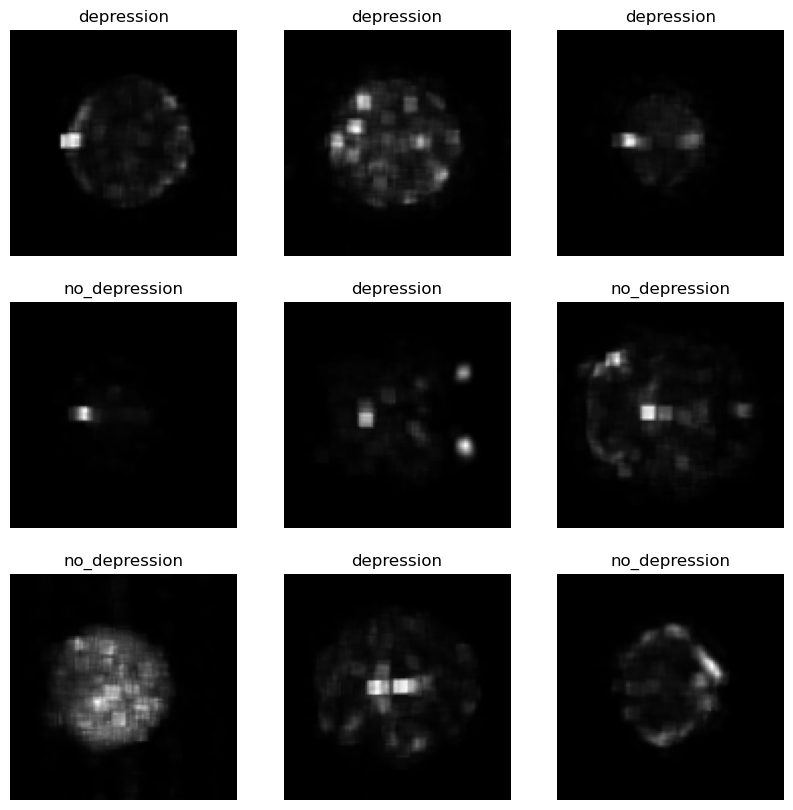

In [6]:
class_names = train_data.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [4]:
mobilenet = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(112, 112, 3))

mobilenet.trainable = False

In [5]:
def preprocess(images, labels):
    return tf.keras.applications.mobilenet_v2.preprocess_input(images), labels

In [6]:
train_data = train_data.map(preprocess)
validation_data = validation_data.map(preprocess)

In [7]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.BatchNormalization(input_shape=(112, 112, 3)))
model.add(mobilenet)
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 112, 112, 3)       12        
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 1280)        5120      
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,265,678
Trainable params: 5,128
Non-trainable params: 2,260,550
__________________________________________

In [8]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=1e-5), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [9]:
history = model.fit(
        train_data,
        epochs = 100,
        validation_data=(validation_data))

2023-01-07 15:35:54.390816: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-01-07 15:35:54.411113: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1804800000 Hz


Epoch 1/100


2023-01-07 15:35:58.139758: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-01-07 15:35:58.457236: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-01-07 15:35:59.867387: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-01-07 15:35:59.930688: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-01-07 15:36:11.283162: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the av

45/45 [==============================] - ETA: 0s - loss: 0.7968 - accuracy: 0.5244

2023-01-07 15:36:32.408481: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 937.06M (982581248 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-01-07 15:36:32.408512: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


45/45 [==============================] - 40s 359ms/step - loss: 0.7969 - accuracy: 0.5245 - val_loss: 0.7946 - val_accuracy: 0.5111
Epoch 2/100
45/45 [==============================] - 5s 110ms/step - loss: 0.7968 - accuracy: 0.5259 - val_loss: 0.7592 - val_accuracy: 0.5500
Epoch 3/100
45/45 [==============================] - 5s 111ms/step - loss: 0.7640 - accuracy: 0.5680 - val_loss: 0.7441 - val_accuracy: 0.5444
Epoch 4/100
45/45 [==============================] - 5s 111ms/step - loss: 0.7598 - accuracy: 0.5623 - val_loss: 0.7364 - val_accuracy: 0.5389
Epoch 5/100
45/45 [==============================] - 5s 111ms/step - loss: 0.7539 - accuracy: 0.5536 - val_loss: 0.7425 - val_accuracy: 0.5167
Epoch 6/100
45/45 [==============================] - 5s 112ms/step - loss: 0.7647 - accuracy: 0.5521 - val_loss: 0.7350 - val_accuracy: 0.5250
Epoch 7/100
45/45 [==============================] - 5s 111ms/step - loss: 0.7651 - accuracy: 0.5386 - val_loss: 0.7233 - val_accuracy: 0.5528
Epoch 8/10

45/45 [==============================] - 6s 120ms/step - loss: 0.6085 - accuracy: 0.6893 - val_loss: 0.6548 - val_accuracy: 0.6722
Epoch 59/100
45/45 [==============================] - 6s 120ms/step - loss: 0.6066 - accuracy: 0.6790 - val_loss: 0.6541 - val_accuracy: 0.6750
Epoch 60/100
45/45 [==============================] - 6s 120ms/step - loss: 0.6072 - accuracy: 0.6755 - val_loss: 0.6537 - val_accuracy: 0.6750
Epoch 61/100
45/45 [==============================] - 6s 120ms/step - loss: 0.6073 - accuracy: 0.6799 - val_loss: 0.6530 - val_accuracy: 0.6750
Epoch 62/100
45/45 [==============================] - 6s 120ms/step - loss: 0.6026 - accuracy: 0.6915 - val_loss: 0.6529 - val_accuracy: 0.6750
Epoch 63/100
45/45 [==============================] - 6s 120ms/step - loss: 0.5855 - accuracy: 0.7122 - val_loss: 0.6523 - val_accuracy: 0.6750
Epoch 64/100
45/45 [==============================] - 6s 120ms/step - loss: 0.6132 - accuracy: 0.6730 - val_loss: 0.6523 - val_accuracy: 0.6750
Epoch

In [10]:
model.save('mobilenet.h5')

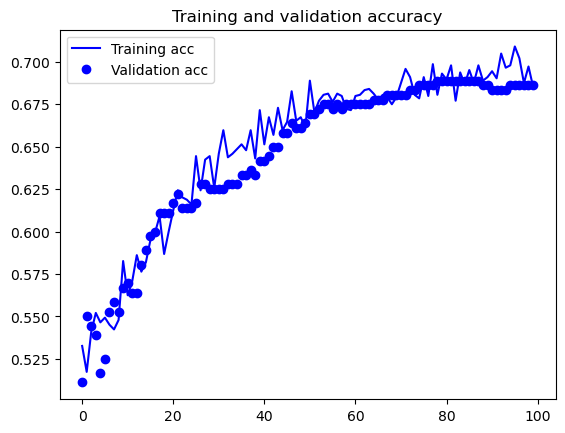

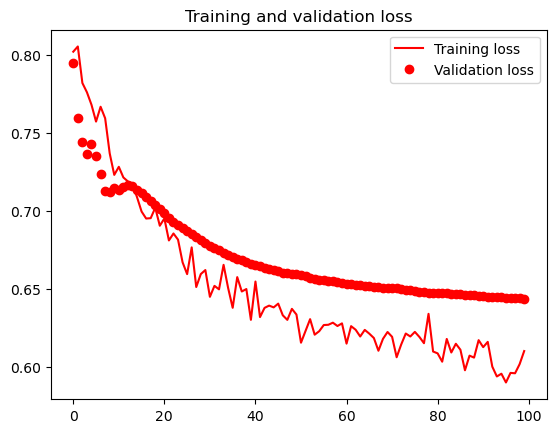

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'bo', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()